In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('../')
from axia import report
from axia import SBGSurvival

from importlib import reload

# Load Subscription Data

In [3]:
with open("./jobber_working_data.pkl", "rb") as f:
    data = pickle.load(f)

In [4]:
data.df.head()

,start_date,end_date,age,alive,subscription_initial,subscription_last,subscription_current,frequency,country,industry
account_id,,,,,,,,,,
2,2011-04-01,NaT,95,1,65.0,128.0,128.0,monthly,canada,painting
34,2012-04-01,NaT,83,1,47.0,47.0,47.0,monthly,canada,arborist_/_tree_care
87,2014-04-01,2015-02-01,10,0,39.0,39.0,0.0,monthly,united_states,lawn_care_&_lawn_maintenance
109,2011-05-01,NaT,94,1,38.0,47.0,47.0,monthly,canada,painting
137,2016-03-01,2016-08-01,5,0,68.0,68.0,0.0,monthly,united_states,mechanical_service


# Retention

In [28]:
def group_colour_map(group_labels, cmap_name="viridis", overwrite_map=None):
    """Slice a color map by group and assing same color to group samples.

    params:
        group_labels (list, array, series): An iterable with a label for
            each sample in the dataset.
        cmap_name (str): Name of the color map to be used
        overwrite_map (RGBA tuple): rgba tuple to use for a particular
            label, overwriting the cmap slice.
    """
    from matplotlib.cm import get_cmap
    from pandas import unique
    cmap = get_cmap(cmap_name)

    if overwrite_map is None:
        overwrite_map = {}

    unique_labels = sorted(unique(group_labels))
    n_labels = len(unique_labels)
    label_index_map = dict(zip(unique_labels, range(n_labels)))

    def rgba(l):
        try:
            return overwrite_map[l]
        except KeyError:
            return cmap(label_index_map[l] / n_labels)

    return [rgba(l) for l in group_labels]

In [208]:
def date_to_quarter(df, col="start_date", n_months=3):
    def _date_to_quarter(dt):
        quarter = ((dt.month - 1) // n_months) + 1
        return dt.replace(month=quarter * n_months, day=1)
    df = df.copy()
    df.insert(0, "start_quarter", df[col].apply(_date_to_quarter))
    return df

In [236]:
retention_actual = (
    data.cdva
    .pipe(date_to_quarter, n_months=3)
    .groupby(["start_quarter", "age"])
    .agg({"alive": "mean"})
)

In [237]:
adf = retention_actual.unstack("age").loc["2014-01-01":].T.reset_index(0, drop=True)

# SBG

In [212]:
N_MONTHS = 12 * 5

In [213]:
dtr = data.dtr.join(data.features())
dva = data.dva.join(data.features())
sample_weight = np.exp(-(((dtr["start_date"].max() - dtr["start_date"]).dt.days / 30 + 1) ** 0.25) + 1)

In [214]:
features = [
    "country",
    "industry",
    "frequency",
    "month_one_retention_trend_s3",
    "month_one_retention_trend_s12",
]

sbg = SBGSurvival(
    age='age',
    alive='alive',
    features=features,
    gamma=1e-3,
    verbose=False
)

In [215]:
%%time
sbg.fit(
    df=dtr,
#     sample_weight=sample_weight,
)

CPU times: user 1min 47s, sys: 1 s, total: 1min 48s
Wall time: 1min 52s


In [216]:
predicted_retention = sbg.predict_survival(dva, age=1, n_periods=N_MONTHS + 1)

In [238]:
retention_sbg = (
    predicted_retention
    .join(data.dva[["start_date"]])
    .reset_index("age")
    .pipe(date_to_quarter, n_months=3)
    .groupby(["start_quarter", "age"])
    .agg({"probability": "mean"})
)

sdf = retention_sbg.unstack("age").loc["2014-01-01":].T.reset_index(0, drop=True)

# Traditional

In [239]:
def _churn_rate(df):
    df["churn_rate"] = (df["is_cancelation_month"] / df["alive"]).fillna(0)
    df["avg_churn_6m"] = df['churn_rate'].rolling(window=6).mean().fillna(0)
    return df[["churn_rate", "avg_churn_6m"]]

def _cross_product(df, other):
    df = df.copy().reset_index()
    df['dummy'] = 1
    df = df.merge(
        other.reset_index(),
        on="dummy",
        how="outer"
    )
    df = df.set_index(["start_quarter", "age"])
    df = df.drop("dummy", axis=1)
    return df.sort_index()

def _retention_rate(df):
    def _retention_by_age(row, col="churn_rate"):
        return (1 - row[col]) ** row["age"]
    df = df.reset_index("age")
    df["churn"] = df.apply(
        lambda row: _retention_by_age(row, "avg_churn_6m"), axis=1)
    
    df = df.set_index('age', append=True)
    return df[["churn"]]
    
    

_age_df = pd.DataFrame(
    data=np.ones(N_MONTHS).astype(int),
    index=pd.Series(range(N_MONTHS), name="age"),
    columns=["dummy"],
)

retention_traditional = (
    data.cdf
    .reset_index("end_of_month")
    .pipe(date_to_quarter, col="end_of_month", n_months=3)
    .groupby("start_quarter")
    .agg({
        'alive': "sum",
        "is_starting_month": 'sum',
        'is_cancelation_month': 'sum',
    })
    .pipe(_churn_rate)
    .pipe(_cross_product, other=_age_df)
    .pipe(_retention_rate)
)


tdf = retention_traditional.unstack("age").loc["2014-01-01":].T.reset_index(0, drop=True)
retention_traditional.tail(10)

churn
start_quarter age          
2019-03-01    50   0.313475
              51   0.306286
              52   0.299262
              53   0.292399
              54   0.285693
              55   0.279141
              56   0.272739
              57   0.266484
              58   0.260373
              59   0.254402

# Global curve

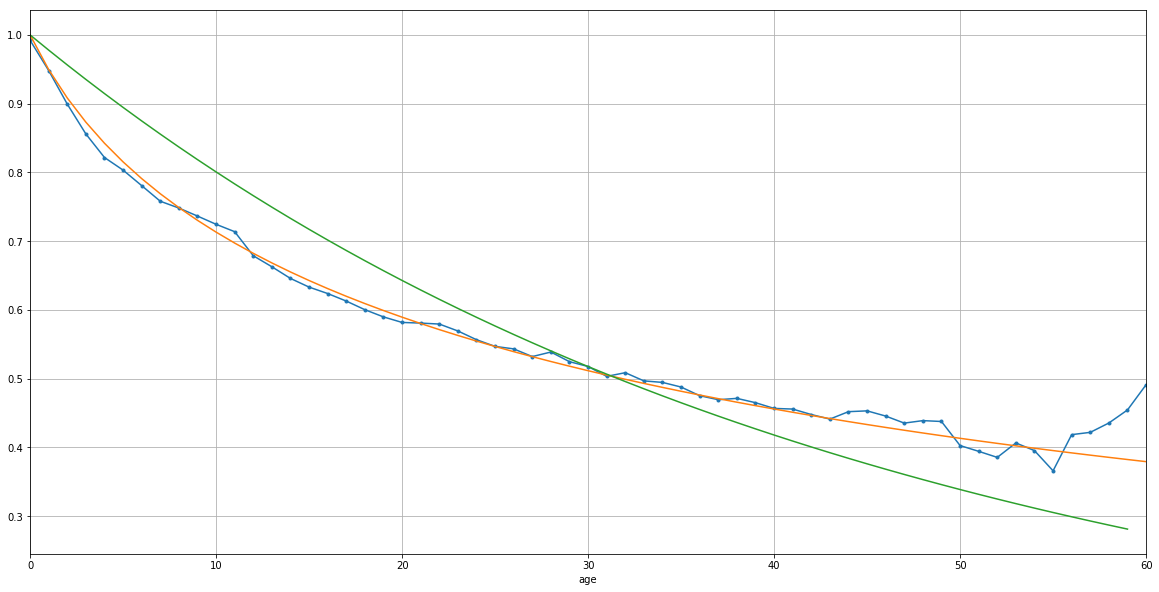

In [295]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

adf.mean(axis=1).plot(ax=ax, style=".-")
sdf.mean(axis=1).plot(ax=ax)
tdf.mean(axis=1).plot(ax=ax)
ax.grid(True)
ax.set_xbound((0, N_MONTHS))

# Together

In [265]:
from sklearn import metrics

In [288]:
retention_all = (
    retention_actual
    .join(retention_sbg)
    .join(retention_traditional)
    .loc["2015-06-01":]
)
retention_all.tail(10)

alive  probability     churn
start_quarter age                                 
2018-09-01    5    0.709877     0.781181  0.894077
              6    0.652542     0.755982  0.874278
              7    0.600000     0.733650  0.854918
2018-12-01    0    0.982759     1.000000  1.000000
              1    0.931034     0.925657  0.977600
              2    0.885057     0.871586  0.955703
              3    0.791304     0.829342  0.934295
              4    0.724138     0.794809  0.913368
2019-03-01    0    0.993007     1.000000  1.000000
              1    0.914286     0.919181  0.977066

In [267]:
print(metrics.mean_absolute_error(retention_all['alive'], retention_all['probability']))
print(metrics.mean_absolute_error(retention_all['alive'], retention_all['churn']))

0.031030973699058044
0.0656672129846495


In [268]:
print(metrics.mean_squared_error(retention_all['alive'], retention_all['probability']))
print(metrics.mean_squared_error(retention_all['alive'], retention_all['churn']))

0.0015847628538957696
0.006201707455882423


In [269]:
(
    retention_all
    .groupby("start_quarter")
    .apply(lambda df: metrics.mean_absolute_error(df['alive'], df['probability']))
    .to_frame()
    .join(
        retention_all
        .groupby("start_quarter")
        .apply(lambda df: metrics.mean_absolute_error(df['alive'], df['churn']))
        .to_frame()
        , rsuffix='_traditional'
        , lsuffix="_sbg"
    )
)

,0_sbg,0_traditional
start_quarter,,
2015-06-01,0.062775,0.095659
2015-09-01,0.034619,0.048033
2015-12-01,0.031713,0.065013
2016-03-01,0.028555,0.043999
2016-06-01,0.012832,0.043882
2016-09-01,0.028787,0.062898
2016-12-01,0.028539,0.047524
2017-03-01,0.029017,0.060458
2017-06-01,0.021533,0.075583


In [276]:
def plot_cohort_retention_lines(df):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))

    colours = group_colour_map([c.strftime("%Y%m%d") for c in df.columns])
    for col, colour in zip(df.columns, colours):
        df[col].plot(c=colour, ax=ax)
    ax.grid(True)
    ax.set_xbound((0, 60))
    
    return fig, ax

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14828cda0>)

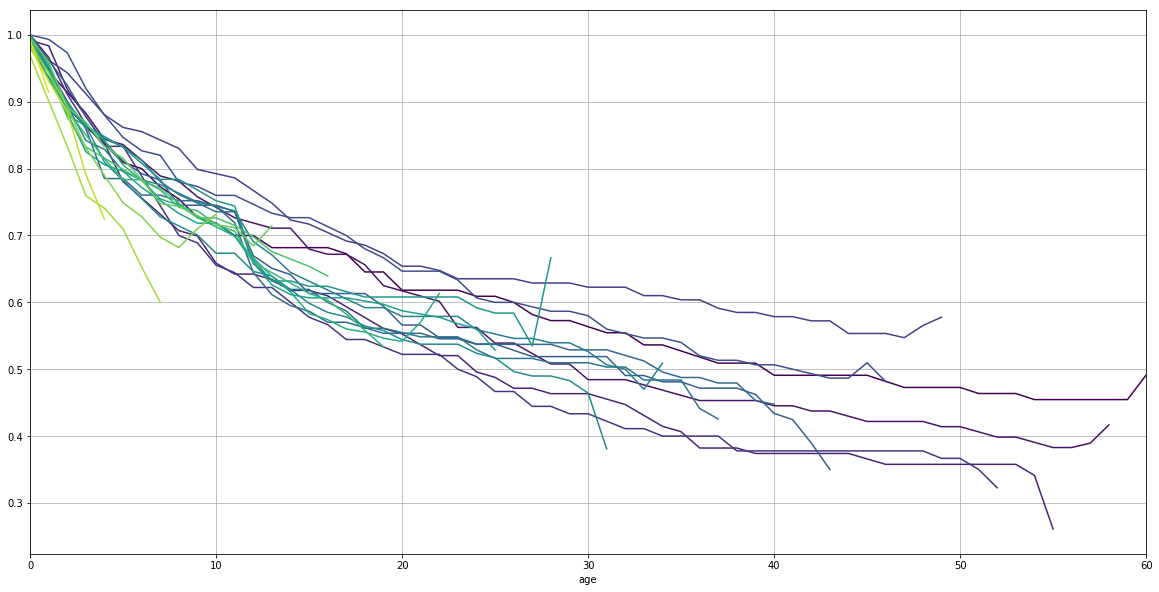

In [277]:
plot_cohort_retention_lines(adf)

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x148298e10>)

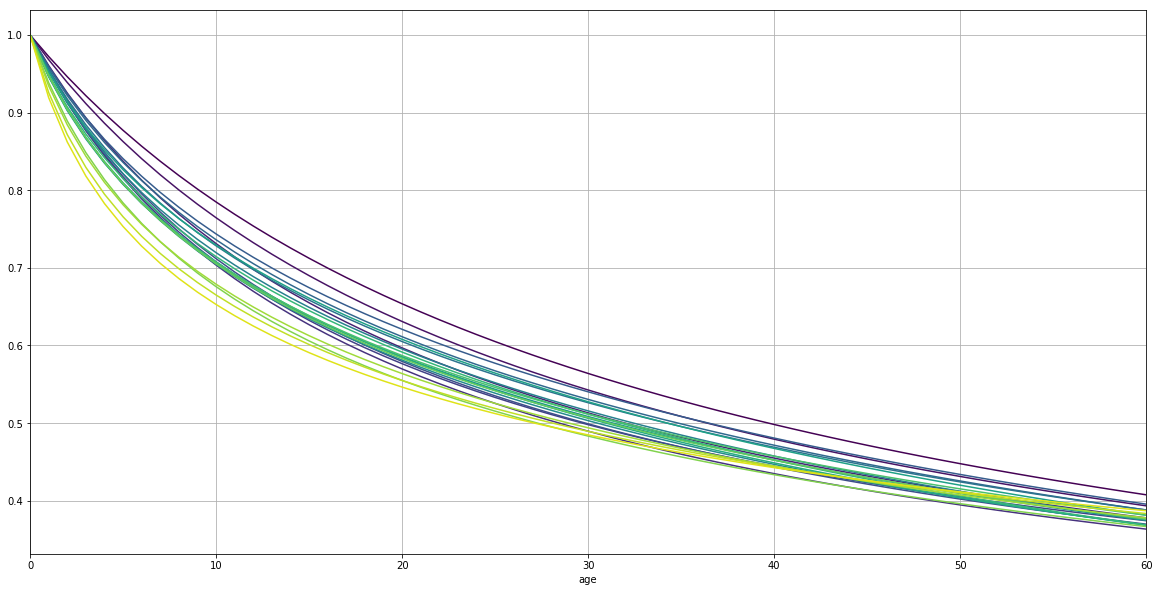

In [278]:
plot_cohort_retention_lines(sdf)

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1489b6d30>)

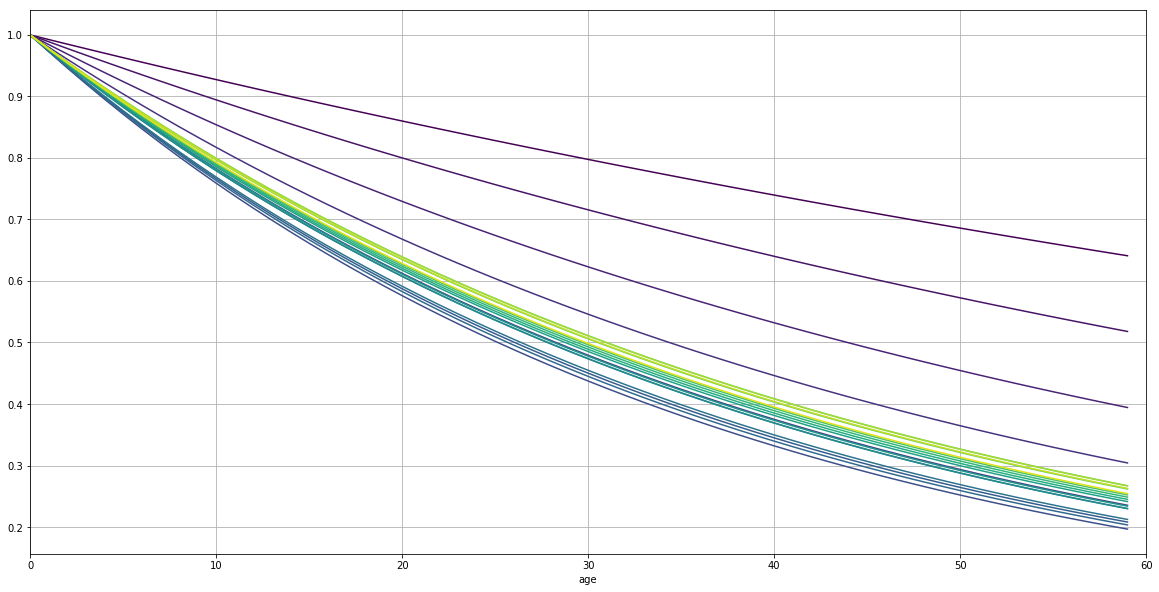

In [279]:
plot_cohort_retention_lines(tdf)

In [ ]:
df.plot()

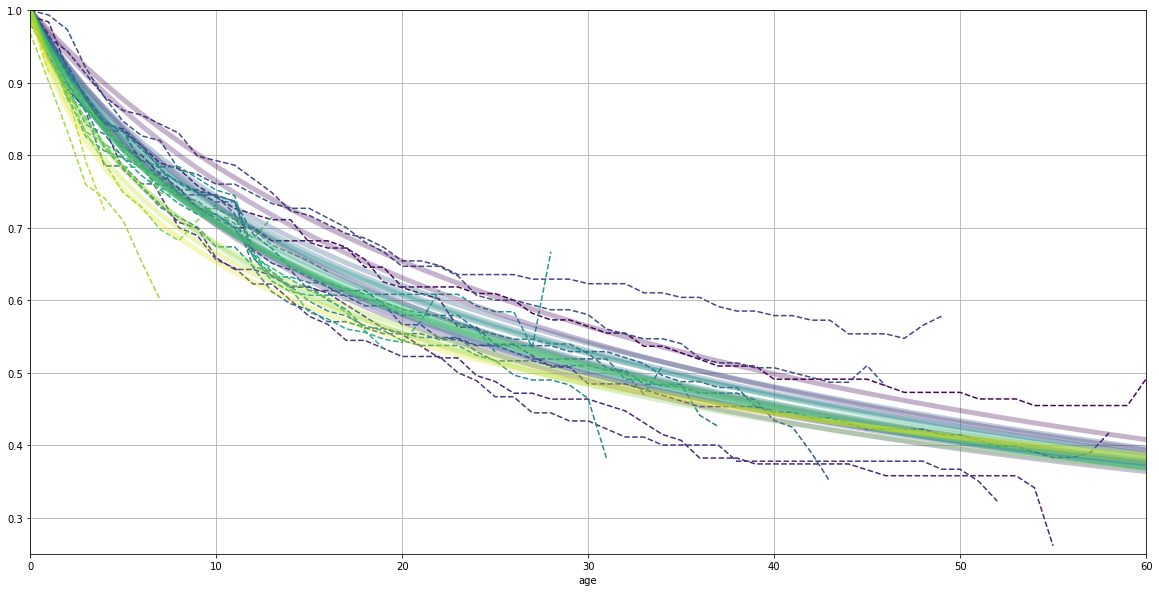

In [294]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

colours = group_colour_map([c.strftime("%Y%m%d") for c in adf.columns])
for col, colour in zip(adf.columns, colours):
    adf[col].plot(style="--", c=colour, ax=ax, alpha=0.99)

colours = group_colour_map([c.strftime("%Y%m%d") for c in sdf.columns])
for col, colour in zip(sdf.columns, colours):
    sdf[col].plot(c=colour, ax=ax, alpha=0.3, linewidth=5)
    
    
ax.grid(True)
ax.set_xbound((0, 60))
ax.set_ybound((0.25, 1))